In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import dagshub

Load Data

In [3]:
# Initialize Dagshub for MLflow tracking
dagshub.init(repo_owner='konstantine25b', repo_name='Machine_learning', mlflow=True)
mlflow.set_experiment("House Prices Experiment - assignment 1") 

Accessing as konstantine25b

Initialized MLflow to track repo "konstantine25b/Machine_learning"

Repository konstantine25b/Machine_learning initialized!

<Experiment: artifact_location='mlflow-artifacts:/4f6e0f8251c84151a7039a3a4cf1bf26', creation_time=1744015407628, experiment_id='0', last_update_time=1744015407628, lifecycle_stage='active', name='House Prices Experiment - assignment 1', tags={}>

In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)
df_train = pd.read_csv('./house-prices/train.csv')
df_test = pd.read_csv('./house-prices/test.csv')

In [5]:
df_train.head


<bound method NDFrame.head of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
0        1          60       RL         65.0     8450   Pave   NaN   

In [6]:
df_train.isna().mean()

Id               0.000000
MSSubClass       0.000000
MSZoning         0.000000
LotFrontage      0.177397
LotArea          0.000000
                   ...   
MoSold           0.000000
YrSold           0.000000
SaleType         0.000000
SaleCondition    0.000000
SalePrice        0.000000
Length: 81, dtype: float64

In [7]:
%pip install seaborn 


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
y_original = df_train['SalePrice']
X_original = df_train.drop('SalePrice', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_original, y_original, test_size=0.2, random_state=42)


In [10]:
print(f"Training data size: X_train - {X_train.shape}, y_train - {y_train.shape}")
print(f"Validation data size: X_val - {X_val.shape}, y_val - {y_val.shape}")


Training data size: X_train - (1168, 80), y_train - (1168,)
Validation data size: X_val - (292, 80), y_val - (292,)


Data Graphs

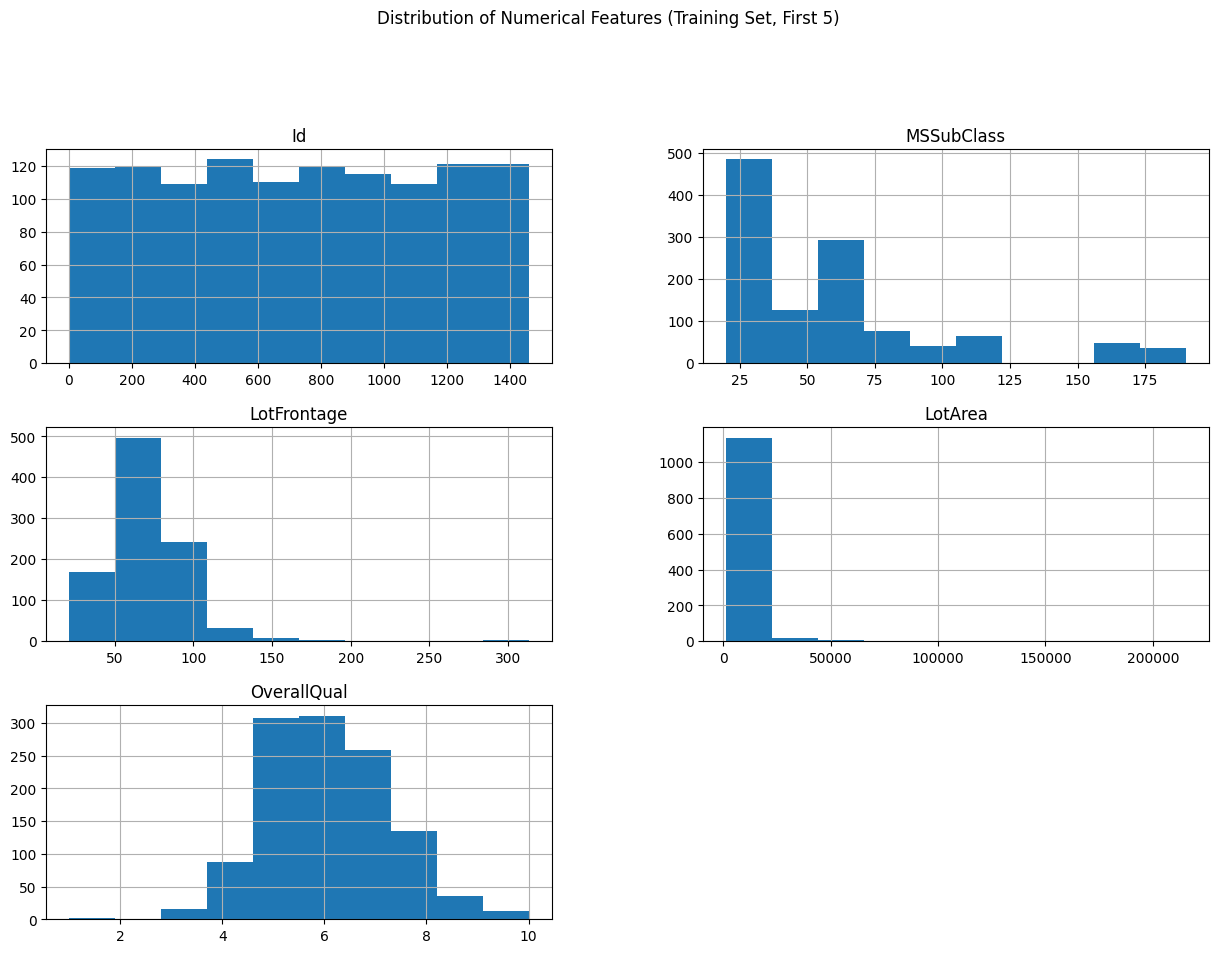

In [11]:
# #### Distribution of Numerical Features (e.g., first 5)
X_train_numerical = X_train.select_dtypes(exclude=['object'])
if not X_train_numerical.empty:
    X_train_numerical.iloc[:, :min(5, X_train_numerical.shape[1])].hist(figsize=(15, 10))
    plt.suptitle("Distribution of Numerical Features (Training Set, First 5)", y=1.02)
    plt.show()

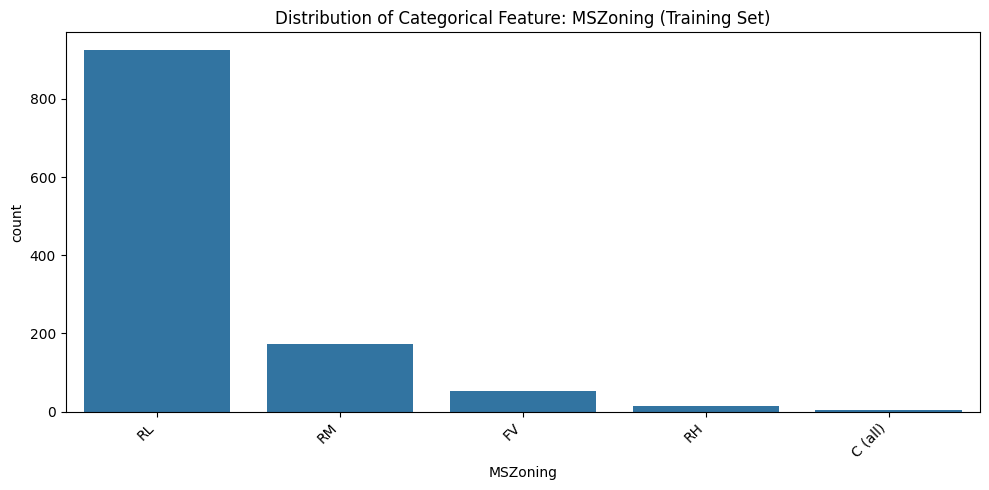

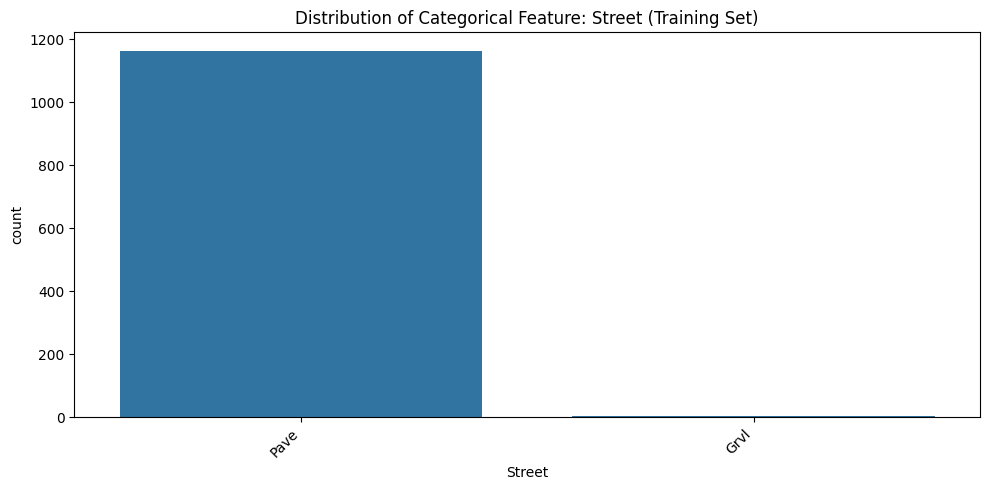

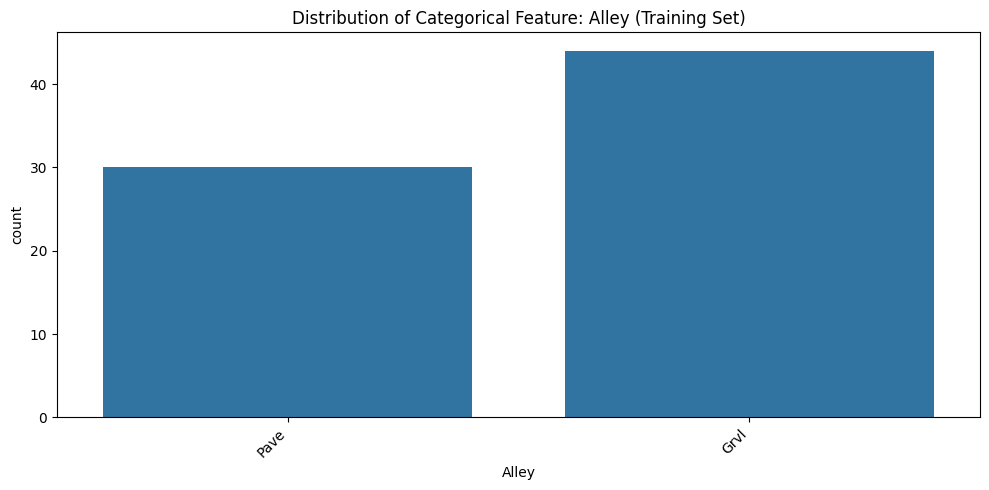

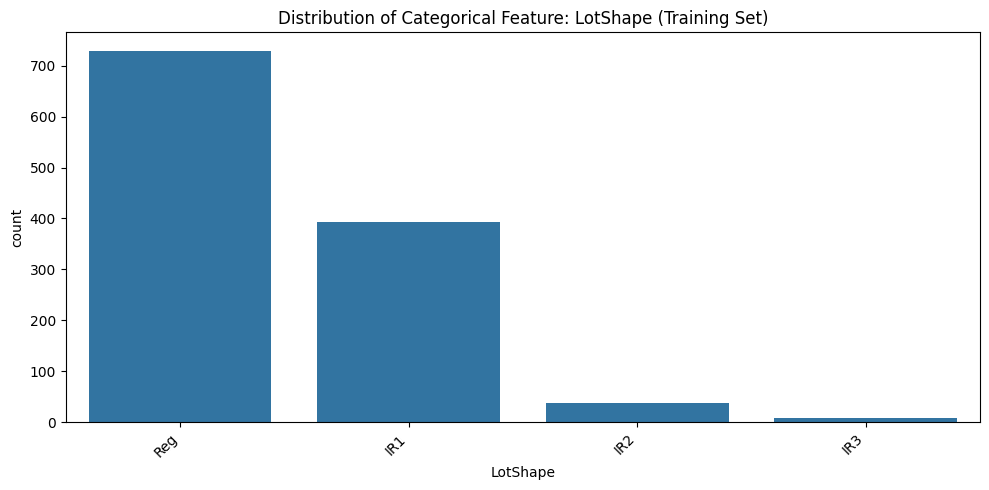

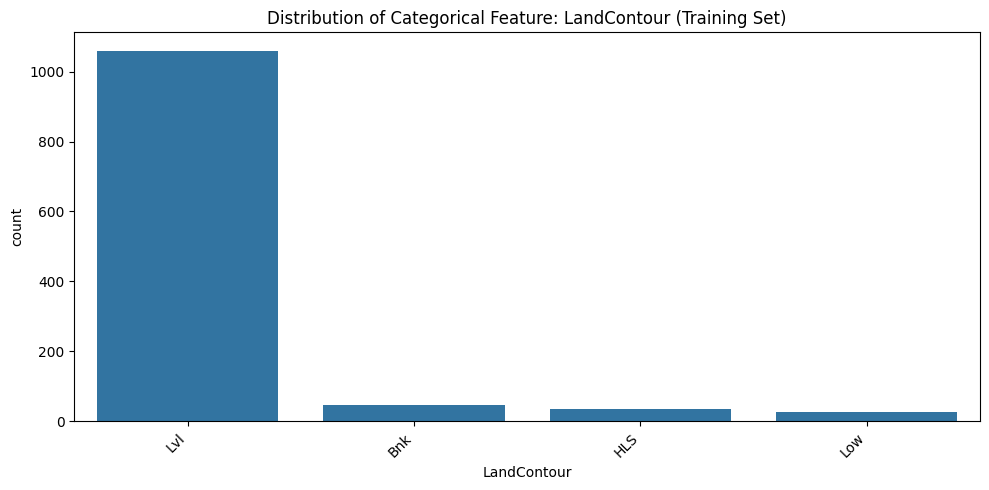

In [12]:
# #### Count of Categorical Features (e.g., first 5)
X_train_categorical = X_train.select_dtypes(include=['object'])
if not X_train_categorical.empty:
    for i, col in enumerate(X_train_categorical.columns[:min(5, len(X_train_categorical.columns))]):
        plt.figure(figsize=(10, 5))
        sns.countplot(data=X_train_categorical, x=col)
        plt.title(f"Distribution of Categorical Feature: {col} (Training Set)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

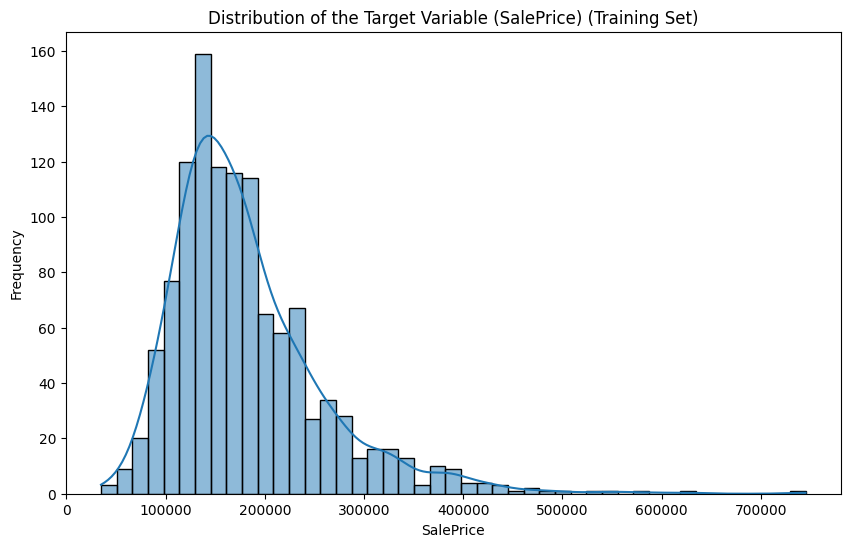

In [13]:
# #### Distribution of the Target Variable (SalePrice)
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True)
plt.title("Distribution of the Target Variable (SalePrice) (Training Set)")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

# Data Cleaning


### Handling Outliers


Handling Outliers in SalePrice (Training Set):
Number of potential outliers in SalePrice (Z-score > 3): 17


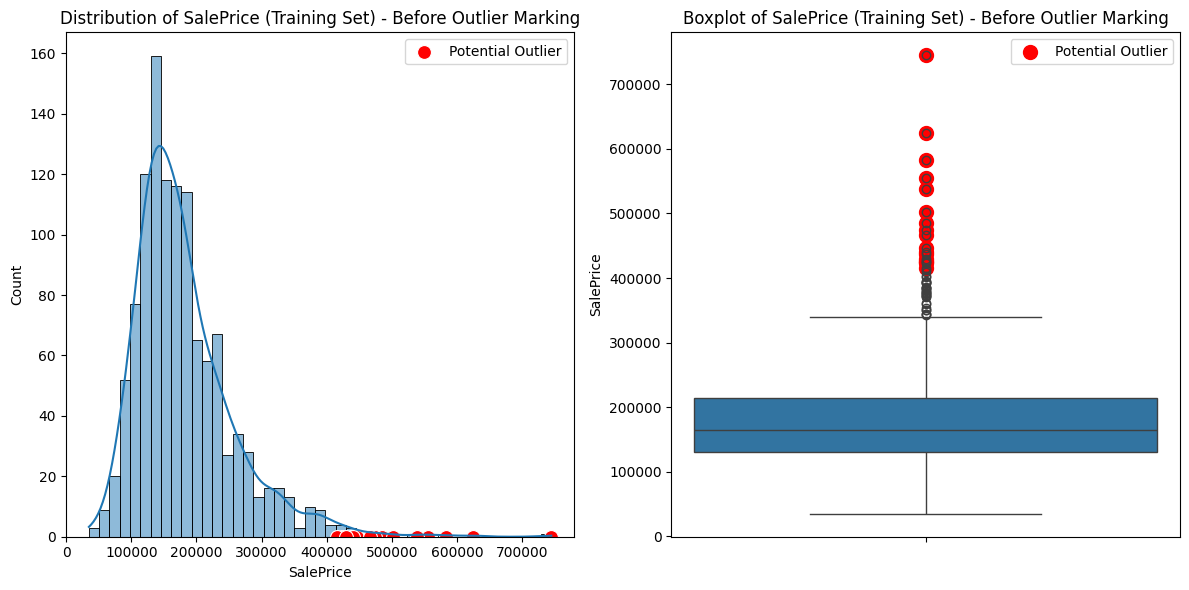


Potential outlier values in SalePrice (Training Set) (Sorted):
278     415298
664     423000
1142    424870
389     426000
496     430000
349     437154
473     440000
527     446261
1373    466500
185     475000
798     485000
178     501837
769     538000
440     555000
803     582933
1169    625000
1182    745000
Name: SalePrice, dtype: int64


In [14]:
# #### Outlier Detection and Removal - SalePrice (Training Set)
from scipy import stats

# #### Outlier Detection and Removal - SalePrice (Training Set)
print("\nHandling Outliers in SalePrice (Training Set):")

# Visualize the distribution of SalePrice
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
plt.title("Distribution of SalePrice (Training Set) - Before Outlier Marking")

# Calculate Z-scores and identify outliers
z_score = np.abs(stats.zscore(y_train))
threshold = 3
outlier_indices = np.where(z_score > threshold)[0]
num_outliers = len(outlier_indices)
print(f"Number of potential outliers in SalePrice (Z-score > {threshold}): {num_outliers}")

# Mark outliers on the histogram
outlier_values = y_train.iloc[outlier_indices]
sns.scatterplot(x=outlier_values, y=[0]*len(outlier_values), color='red', marker='o', s=100, label='Potential Outlier')
plt.legend()

# Boxplot to visualize outliers
plt.subplot(1, 2, 2)
sns.boxplot(y=y_train)
plt.title("Boxplot of SalePrice (Training Set) - Before Outlier Marking")
plt.scatter(y=outlier_values, x=[0]*len(outlier_values), color='red', marker='o', s=100, label='Potential Outlier')
plt.xlabel('') # Remove x-axis label for better focus on y
plt.legend()

plt.tight_layout()
plt.show()

print("\nPotential outlier values in SalePrice (Training Set) (Sorted):")
print(y_train.iloc[outlier_indices].sort_values())


Training data size after removing SalePrice outliers: X_train - (1151, 80), y_train - (1151,)


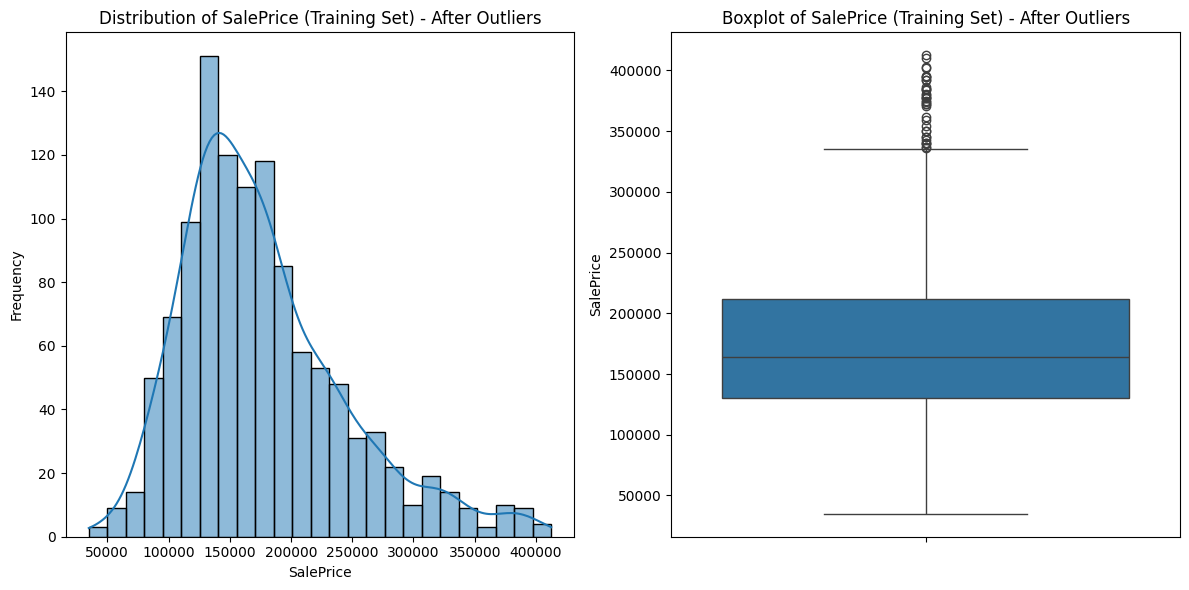

In [15]:

# Now proceed with removing the identified outliers
X_train_filtered = X_train.iloc[~np.isin(X_train.index, y_train.iloc[outlier_indices].index)]
y_train_filtered = y_train.iloc[~np.isin(y_train.index, y_train.iloc[outlier_indices].index)]

print(f"Training data size after removing SalePrice outliers: X_train - {X_train_filtered.shape}, y_train - {y_train_filtered.shape}")

# Update training sets
X_train = X_train_filtered
y_train = y_train_filtered

# #### Distribution of the Target Variable (SalePrice) - After Outlier Handling
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
plt.title("Distribution of SalePrice (Training Set) - After Outliers")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(y=y_train)
plt.title("Boxplot of SalePrice (Training Set) - After Outliers")
plt.ylabel("SalePrice")

plt.tight_layout()
plt.show()

### Handling missing values (NA Filling)

In [16]:
# Identify categorical and numerical columns after outlier removal
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns

print("\nHandling Missing Values (NA Filling) - After Outlier Removal:")
print("\nMissing values in Training Set (before imputation):")
print(X_train.isnull().sum().sort_values(ascending=False).head(20)) # Show top 20

print("\nMissing values in Validation Set (before imputation):")
print(X_val.isnull().sum().sort_values(ascending=False).head(20)) # Show top 20



Handling Missing Values (NA Filling) - After Outlier Removal:

Missing values in Training Set (before imputation):
PoolQC          1146
MiscFeature     1105
Alley           1077
Fence            920
MasVnrType       679
FireplaceQu      547
LotFrontage      215
GarageCond        64
GarageType        64
GarageYrBlt       64
GarageQual        64
GarageFinish      64
BsmtFinType2      28
BsmtFinType1      28
BsmtExposure      28
BsmtCond          28
BsmtQual          28
MasVnrArea         6
Electrical         1
BedroomAbvGr       0
dtype: int64

Missing values in Validation Set (before imputation):
PoolQC          291
MiscFeature     284
Alley           275
Fence           244
MasVnrType      189
FireplaceQu     143
LotFrontage      42
GarageCond       17
GarageType       17
GarageYrBlt      17
GarageQual       17
GarageFinish     17
BsmtExposure     10
BsmtFinType2     10
BsmtFinType1      9
BsmtCond          9
BsmtQual          9
MasVnrArea        2
KitchenAbvGr      0
KitchenQual     

In [17]:
# Identify columns with a high percentage of missing values
cols_to_drop_na = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
print("\nHandling Missing Values (NA Filling) - After Outlier Removal:")
print(f"\nDropping columns with high missing values: {cols_to_drop_na}")



Handling Missing Values (NA Filling) - After Outlier Removal:

Dropping columns with high missing values: ['PoolQC', 'MiscFeature', 'Alley', 'Fence']


In [18]:

# Drop these columns from both training and validation sets
X_train.drop(columns=cols_to_drop_na, errors='ignore', inplace=True)
X_val.drop(columns=cols_to_drop_na, errors='ignore', inplace=True)

print("\nMissing values in Training Set (after dropping columns):")
print(X_train.isnull().sum().sort_values(ascending=False).head(20))





Missing values in Training Set (after dropping columns):
MasVnrType      679
FireplaceQu     547
LotFrontage     215
GarageCond       64
GarageType       64
GarageYrBlt      64
GarageFinish     64
GarageQual       64
BsmtFinType2     28
BsmtFinType1     28
BsmtExposure     28
BsmtCond         28
BsmtQual         28
MasVnrArea        6
Electrical        1
PavedDrive        0
PoolArea          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
dtype: int64


In [19]:
print("\nMissing values in Validation Set (after dropping columns):")
print(X_val.isnull().sum().sort_values(ascending=False).head(20))


Missing values in Validation Set (after dropping columns):
MasVnrType      189
FireplaceQu     143
LotFrontage      42
GarageType       17
GarageYrBlt      17
GarageFinish     17
GarageQual       17
GarageCond       17
BsmtFinType2     10
BsmtExposure     10
BsmtFinType1      9
BsmtCond          9
BsmtQual          9
MasVnrArea        2
BedroomAbvGr      0
HalfBath          0
FullBath          0
BsmtHalfBath      0
KitchenAbvGr      0
BsmtFullBath      0
dtype: int64


In [20]:
# Identify categorical and numerical columns after dropping and outlier removal
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(exclude=['object']).columns


In [21]:
# #### Numerical Features - Impute with Median
numerical_imputer = SimpleImputer(strategy='median')
X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = numerical_imputer.transform(X_val[numerical_cols]) # Use the same imputer

print("\nMissing values in Training Set (after numerical imputation):")
print(X_train[numerical_cols].isnull().sum().sort_values(ascending=False).head(20))

print("\nMissing values in Validation Set (after numerical imputation):")
print(X_val[numerical_cols].isnull().sum().sort_values(ascending=False).head(20))



Missing values in Training Set (after numerical imputation):
Id               0
FullBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
HalfBath         0
BsmtHalfBath     0
MSSubClass       0
dtype: int64

Missing values in Validation Set (after numerical imputation):
Id               0
FullBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
HalfBath         0
BsmtHalfBath     0
MSSubClass       0
dtype: int64


In [22]:
# #### Categorical Features - Impute with Most Frequent
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
X_val[categorical_cols] = categorical_imputer.transform(X_val[categorical_cols]) # Use the same imputer

print("\nMissing values in Training Set (after categorical imputation):")
print(X_train[categorical_cols].isnull().sum().sort_values(ascending=False).head())

print("\nMissing values in Validation Set (after categorical imputation):")
print(X_val[categorical_cols].isnull().sum().sort_values(ascending=False).head())



Missing values in Training Set (after categorical imputation):
MSZoning        0
KitchenQual     0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64

Missing values in Validation Set (after categorical imputation):
MSZoning        0
KitchenQual     0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64


In [23]:
print("\nTotal missing values in Training Set (after imputation):")
print(X_train.isnull().sum().sum())

print("\nTotal missing values in Validation Set (after imputation):")
print(X_val.isnull().sum().sum())


Total missing values in Training Set (after imputation):
0

Total missing values in Validation Set (after imputation):
0


### Current progress

In [24]:
# ### Display the Processed DataFrames

print("\nProcessed Training Set (First 5 rows):")
print(X_train.head(10))
print("\nShape of Processed Training Set:", X_train.shape)

print("\nProcessed Validation Set (First 5 rows):")
print(X_val.head(10))
print("\nShape of Processed Validation Set:", X_val.shape)



Processed Training Set (First 5 rows):
          Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold SaleType SaleCondition
254    255.0        20.0       RL         70.0   8400.0   Pave      Reg         Lvl    AllPub    Ins

# Feature Engineering

In [25]:
X_train['TotalRemodYears'] = X_train['YrSold'] - X_train['YearRemodAdd']
X_val['TotalRemodYears'] = X_val['YrSold'] - X_val['YearRemodAdd']
X_train['TotalBuiltAge'] = X_train['YrSold'] - X_train['YearBuilt']
X_val['TotalBuiltAge'] = X_val['YrSold'] - X_val['YearBuilt']

X_train['LivingAreaRatio'] = X_train['GrLivArea'] / X_train['LotArea']
X_val['LivingAreaRatio'] = X_val['GrLivArea'] / X_val['LotArea']
X_train['BasementSurfaceRatio'] = X_train['TotalBsmtSF'] / X_train['LotArea']
X_val['BasementSurfaceRatio'] = X_val['TotalBsmtSF'] / X_val['LotArea']



In [26]:
# ### Display the Processed DataFrames

print("\nProcessed Training Set (First 5 rows):")
print(X_train.head(100))
print("\nShape of Processed Training Set:", X_train.shape)

print("\nProcessed Validation Set (First 5 rows):")
print(X_val.head(100))
print("\nShape of Processed Validation Set:", X_val.shape)


Processed Training Set (First 5 rows):
          Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold SaleType SaleCondition  TotalRemodYears  TotalBuiltAge  LivingAreaRatio  BasementSurfaceRatio
254    255.0        20.0     

### Correlation Removal

In [27]:
# Identify numerical columns
numerical_cols_engineered = X_train.select_dtypes(exclude=['object']).columns

# Calculate the correlation matrix for numerical features
corr_matrix = X_train[numerical_cols_engineered].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns with high correlation (threshold of 0.7 - can be adjusted)
threshold = 0.7
cols_to_drop_corr = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"\nHighly correlated numerical features (correlation > {threshold}):")
print(cols_to_drop_corr)

# Drop the highly correlated columns
X_train_uncorr = X_train.drop(columns=cols_to_drop_corr, errors='ignore')
X_val_uncorr = X_val.drop(columns=cols_to_drop_corr, errors='ignore')

print("\nShape of Training Set after Correlation Removal:", X_train_uncorr.shape)
print("Shape of Validation Set after Correlation Removal:", X_val_uncorr.shape)



Highly correlated numerical features (correlation > 0.7):
['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'TotalRemodYears', 'TotalBuiltAge', 'BasementSurfaceRatio']

Shape of Training Set after Correlation Removal: (1151, 73)
Shape of Validation Set after Correlation Removal: (292, 73)


### One-Hot Encoding

In [28]:
# Identify categorical columns in the uncorrected sets
categorical_cols_uncorr = X_train_uncorr.select_dtypes(include=['object']).columns

# Create OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the training data
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train_uncorr[categorical_cols_uncorr]))
X_train_encoded.columns = encoder.get_feature_names_out(categorical_cols_uncorr)
X_train_encoded.index = X_train_uncorr.index

# Transform the validation data
X_val_encoded = pd.DataFrame(encoder.transform(X_val_uncorr[categorical_cols_uncorr]))
X_val_encoded.columns = encoder.get_feature_names_out(categorical_cols_uncorr)
X_val_encoded.index = X_val_uncorr.index

# Drop original categorical columns and concatenate encoded columns
X_train_processed = pd.concat([X_train_uncorr.drop(columns=categorical_cols_uncorr, errors='ignore'), X_train_encoded], axis=1)
X_val_processed = pd.concat([X_val_uncorr.drop(columns=categorical_cols_uncorr, errors='ignore'), X_val_encoded], axis=1)

print("\nShape of Training Set after One-Hot Encoding:", X_train_processed.shape)
print("Shape of Validation Set after One-Hot Encoding:", X_val_processed.shape)



Shape of Training Set after One-Hot Encoding: (1151, 270)
Shape of Validation Set after One-Hot Encoding: (292, 270)


### RFE

In [29]:
from sklearn.feature_selection import RFE

# --- Using StandardScaler for RFE ---
print("\nFeature Selection using RFE with StandardScaler:")

# Identify numerical columns for scaling
numerical_cols_final_standard = X_train_processed.select_dtypes(exclude=['object']).columns

# Create a pipeline with StandardScaler and Linear Regression for RFE
rfe_pipeline_standard = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', LinearRegression())
])

# Define a function to get coefficients from the estimator in the pipeline
def get_rfe_estimator_coef_standard(estimator):
    return estimator.named_steps['estimator'].coef_

# Initialize RFE, explicitly specifying how to get feature importance
rfe_standard = RFE(estimator=rfe_pipeline_standard, n_features_to_select=50, importance_getter=get_rfe_estimator_coef_standard) # Select top 50 features
rfe_standard.fit(X_train_processed, y_train)

# Get the selected feature indices and names
selected_feature_indices_rfe_standard = rfe_standard.support_
selected_features_rfe_standard = X_train_processed.columns[selected_feature_indices_rfe_standard]

print(f"\nSelected top {len(selected_features_rfe_standard)} features using RFE (StandardScaler):")
print(selected_features_rfe_standard)

# Filter the training and validation sets to include only the selected features
X_train_selected_rfe_standard = X_train_processed[selected_features_rfe_standard]
X_val_selected_rfe_standard = X_val_processed[selected_features_rfe_standard]

print("\nShape of Training Set after RFE (StandardScaler):", X_train_selected_rfe_standard.shape)
print("Shape of Validation Set after RFE (StandardScaler):", X_val_selected_rfe_standard.shape)

# ### Final Preprocessing for Modeling (Scaling after RFE with StandardScaler)

print("\nFinal Preprocessing for Modeling (Scaling after RFE with StandardScaler):")

scaler_final_standard = StandardScaler()
X_train_prepared_rfe_standard = scaler_final_standard.fit_transform(X_train_selected_rfe_standard)
X_val_prepared_rfe_standard = scaler_final_standard.transform(X_val_selected_rfe_standard)

print("\nShape of Prepared Training Data (after RFE and StandardScaler):", X_train_prepared_rfe_standard.shape)
print("Shape of Prepared Validation Data (after RFE and StandardScaler):", X_val_prepared_rfe_standard.shape)

# --- Using MinMaxScaler for RFE ---
print("\nFeature Selection using RFE with MinMaxScaler:")

# Identify numerical columns for scaling (already defined)

# Create a pipeline with MinMaxScaler and Linear Regression for RFE
rfe_pipeline_minmax = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', LinearRegression())
])

# Define a function to get coefficients from the estimator in the pipeline
def get_rfe_estimator_coef_minmax(estimator):
    return estimator.named_steps['estimator'].coef_

# Initialize RFE, explicitly specifying how to get feature importance
rfe_minmax = RFE(estimator=rfe_pipeline_minmax, n_features_to_select=50, importance_getter=get_rfe_estimator_coef_minmax) # Select top 50 features
rfe_minmax.fit(X_train_processed, y_train)

# Get the selected feature indices and names
selected_feature_indices_rfe_minmax = rfe_minmax.support_
selected_features_rfe_minmax = X_train_processed.columns[selected_feature_indices_rfe_minmax]

print(f"\nSelected top {len(selected_features_rfe_minmax)} features using RFE (MinMaxScaler):")
print(selected_features_rfe_minmax)

# Filter the training and validation sets to include only the selected features
X_train_selected_rfe_minmax = X_train_processed[selected_features_rfe_minmax]
X_val_selected_rfe_minmax = X_val_processed[selected_features_rfe_minmax]

print("\nShape of Training Set after RFE (MinMaxScaler):", X_train_selected_rfe_minmax.shape)
print("Shape of Validation Set after RFE (MinMaxScaler):", X_val_selected_rfe_minmax.shape)

# ### Final Preprocessing for Modeling (Scaling after RFE with MinMaxScaler)

print("\nFinal Preprocessing for Modeling (Scaling after RFE with MinMaxScaler):")

scaler_final_minmax = MinMaxScaler()
X_train_prepared_rfe_minmax = scaler_final_minmax.fit_transform(X_train_selected_rfe_minmax)
X_val_prepared_rfe_minmax = scaler_final_minmax.transform(X_val_selected_rfe_minmax)

print("\nShape of Prepared Training Data (after RFE and MinMaxScaler):", X_train_prepared_rfe_minmax.shape)
print("Shape of Prepared Validation Data (after RFE and MinMaxScaler):", X_val_prepared_rfe_minmax.shape)


Feature Selection using RFE with StandardScaler:

Selected top 50 features using RFE (StandardScaler):
Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath',
       'Fireplaces', 'GarageCars', 'WoodDeckSF', 'LivingAreaRatio',
       'MSZoning_FV', 'LandContour_HLS', 'Neighborhood_Blmngtn',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor',
       'Neighborhood_NPkVill', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker',
       'Condition1_Artery', 'Condition2_PosA', 'Condition2_PosN',
       'BldgType_1Fam', 'RoofStyle_Gable', 'RoofStyle_Hip', 'RoofMatl_ClyTile',
       'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_Wd Sdng',
       'Exterior2nd_CmentBd', 'Exterior2nd_Wd Sdng', 'ExterQual_Ex',
       'Foundation_PConc', 'BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA',
       '

In [30]:

print("\nFirst 5 rows of Training Set after RFE (MinMaxScaler):")
print(X_train_selected_rfe_minmax.head())

print("\nFirst 5 rows of Validation Set after RFE (MinMaxScaler):")
print(X_val_selected_rfe_minmax.head())


First 5 rows of Training Set after RFE (MinMaxScaler):
      LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  BsmtFinSF1  TotalBsmtSF  GrLivArea  BsmtFullBath  GarageCars  3SsnPorch  LivingAreaRatio  MSZoning_FV  LandContour_HLS  Utilities_AllPub  LandSlope_Sev  Neighborhood_Blmngtn  Neighborhood_Blueste  Neighborhood_Crawfor  Neighborhood_NPkVill  Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_StoneBr  Neighborhood_Veenker  Condition1_RRAe  Condition2_PosA  Condition2_PosN  Condition2_RRAe  BldgType_1Fam  RoofStyle_Shed  RoofMatl_ClyTile  RoofMatl_CompShg  RoofMatl_Metal  RoofMatl_Roll  RoofMatl_Tar&Grv  RoofMatl_WdShake  RoofMatl_WdShngl  Exterior1st_BrkFace  Exterior1st_CemntBd  Exterior2nd_CmentBd  Foundation_Wood  BsmtQual_Ex  BsmtCond_Po  Heating_OthW  Heating_Wall  KitchenQual_Ex  Functional_Sev  GarageType_2Types  SaleType_Con  SaleType_Oth
254          70.0   8400.0          5.0          6.0     1957.0       922.0       1314.0     1314.0           1.0     

# Model Training with K-Fold Cross-Validation and Grid Search 

In [31]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Define scoring metrics
scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']


In [32]:

# --- Linear Regression on features selected by RFE with StandardScaler ---
print("\nEvaluating Linear Regression (RFE with StandardScaler):")
pipeline_lr_standard = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_reg', LinearRegression())
])
param_grid_lr_standard = {}

grid_search_lr_standard = GridSearchCV(pipeline_lr_standard, param_grid_lr_standard, scoring=scoring, cv=kf, n_jobs=-1, refit='neg_root_mean_squared_error')
grid_search_lr_standard.fit(X_train_selected_rfe_standard, y_train)

best_rmse_lr_standard = -grid_search_lr_standard.best_score_
best_mae_lr_standard = -grid_search_lr_standard.cv_results_['mean_test_neg_mean_absolute_error'][grid_search_lr_standard.best_index_]
best_r2_lr_standard = grid_search_lr_standard.cv_results_['mean_test_r2'][grid_search_lr_standard.best_index_]

print(f"Best CV RMSE (Linear Regression, StandardScaler RFE): {best_rmse_lr_standard:.4f}")
print(f"Best CV MAE (Linear Regression, StandardScaler RFE): {best_mae_lr_standard:.4f}")
print(f"Best CV R-squared (Linear Regression, StandardScaler RFE): {best_r2_lr_standard:.4f}")

# Calculate training scores
best_lr_model_standard = grid_search_lr_standard.best_estimator_
y_train_pred_lr_standard = best_lr_model_standard.predict(X_train_selected_rfe_standard)
train_rmse_lr_standard = np.sqrt(mean_squared_error(y_train, y_train_pred_lr_standard))
train_mae_lr_standard = mean_absolute_error(y_train, y_train_pred_lr_standard)
train_r2_lr_standard = r2_score(y_train, y_train_pred_lr_standard)

print(f"Training RMSE (Linear Regression, StandardScaler RFE): {train_rmse_lr_standard:.4f}")
print(f"Training MAE (Linear Regression, StandardScaler RFE): {train_mae_lr_standard:.4f}")
print(f"Training R-squared (Linear Regression, StandardScaler RFE): {train_r2_lr_standard:.4f}")

with mlflow.start_run(nested=True):
    mlflow.set_tag("model", "LinearRegression_RFE_StandardScaler")
    mlflow.log_metric("best_cv_rmse", best_rmse_lr_standard)
    mlflow.log_metric("best_cv_mae", best_mae_lr_standard)
    mlflow.log_metric("best_cv_r2", best_r2_lr_standard)
    mlflow.log_metric("train_rmse", train_rmse_lr_standard)
    mlflow.log_metric("train_mae", train_mae_lr_standard)
    mlflow.log_metric("train_r2", train_r2_lr_standard)
    mlflow.sklearn.log_model(grid_search_lr_standard.best_estimator_, "linear_regression_rfe_standardscaler", input_example=X_train_selected_rfe_standard.head())



Evaluating Linear Regression (RFE with StandardScaler):
Best CV RMSE (Linear Regression, StandardScaler RFE): 27684.9814
Best CV MAE (Linear Regression, StandardScaler RFE): 14656.8376
Best CV R-squared (Linear Regression, StandardScaler RFE): 0.8107
Training RMSE (Linear Regression, StandardScaler RFE): 19076.2953
Training MAE (Linear Regression, StandardScaler RFE): 12994.0222
Training R-squared (Linear Regression, StandardScaler RFE): 0.9185
🏃 View run bouncy-ape-817 at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/fd120065e73a427b949a2c1e301bff8b
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0


In [33]:

# --- Linear Regression on features selected by RFE with MinMaxScaler ---
print("\nEvaluating Linear Regression (RFE with MinMaxScaler):")
pipeline_lr_minmax = Pipeline([
    ('scaler', MinMaxScaler()),
    ('linear_reg', LinearRegression())
])
param_grid_lr_minmax = {}

grid_search_lr_minmax = GridSearchCV(pipeline_lr_minmax, param_grid_lr_minmax, scoring=scoring, cv=kf, n_jobs=-1, refit='neg_root_mean_squared_error')
grid_search_lr_minmax.fit(X_train_selected_rfe_minmax, y_train)

best_rmse_lr_minmax = -grid_search_lr_minmax.best_score_
best_mae_lr_minmax = -grid_search_lr_minmax.cv_results_['mean_test_neg_mean_absolute_error'][grid_search_lr_minmax.best_index_]
best_r2_lr_minmax = grid_search_lr_minmax.cv_results_['mean_test_r2'][grid_search_lr_minmax.best_index_]

print(f"Best CV RMSE (Linear Regression, MinMaxScaler RFE): {best_rmse_lr_minmax:.4f}")
print(f"Best CV MAE (Linear Regression, MinMaxScaler RFE): {best_mae_lr_minmax:.4f}")
print(f"Best CV R-squared (Linear Regression, MinMaxScaler RFE): {best_r2_lr_minmax:.4f}")

# Calculate training scores
best_lr_model_minmax = grid_search_lr_minmax.best_estimator_
y_train_pred_lr_minmax = best_lr_model_minmax.predict(X_train_selected_rfe_minmax)
train_rmse_lr_minmax = np.sqrt(mean_squared_error(y_train, y_train_pred_lr_minmax))
train_mae_lr_minmax = mean_absolute_error(y_train, y_train_pred_lr_minmax)
train_r2_lr_minmax = r2_score(y_train, y_train_pred_lr_minmax)

print(f"Training RMSE (Linear Regression, MinMaxScaler RFE): {train_rmse_lr_minmax:.4f}")
print(f"Training MAE (Linear Regression, MinMaxScaler RFE): {train_mae_lr_minmax:.4f}")
print(f"Training R-squared (Linear Regression, MinMaxScaler RFE): {train_r2_lr_minmax:.4f}")

with mlflow.start_run(nested=True):
    mlflow.set_tag("model", "LinearRegression_RFE_MinMaxScaler")
    mlflow.log_metric("best_cv_rmse", best_rmse_lr_minmax)
    mlflow.log_metric("best_cv_mae", best_mae_lr_minmax)
    mlflow.log_metric("best_cv_r2", best_r2_lr_minmax)
    mlflow.log_metric("train_rmse", train_rmse_lr_minmax)
    mlflow.log_metric("train_mae", train_mae_lr_minmax)
    mlflow.log_metric("train_r2", train_r2_lr_minmax)
    mlflow.sklearn.log_model(grid_search_lr_minmax.best_estimator_, "linear_regression_rfe_minmaxscaler", input_example=X_train_selected_rfe_minmax.head())



Evaluating Linear Regression (RFE with MinMaxScaler):
Best CV RMSE (Linear Regression, MinMaxScaler RFE): 29815.3397
Best CV MAE (Linear Regression, MinMaxScaler RFE): 16391.6017
Best CV R-squared (Linear Regression, MinMaxScaler RFE): 0.7842
Training RMSE (Linear Regression, MinMaxScaler RFE): 20540.5669
Training MAE (Linear Regression, MinMaxScaler RFE): 14120.4982
Training R-squared (Linear Regression, MinMaxScaler RFE): 0.9055
🏃 View run rebellious-lynx-101 at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/18bb0faa0b1f463d8339bdf7aa1c872c
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0


In [34]:

# --- Decision Tree Regression on features selected by RFE with StandardScaler ---
print("\nEvaluating Decision Tree Regression (RFE with StandardScaler):")
pipeline_dt_standard = Pipeline([
    ('scaler', StandardScaler()),
    ('tree_reg', DecisionTreeRegressor(random_state=42))
])
param_grid_dt_reduced_overfitting = {
    'tree_reg__max_depth': [None, 5, 7, 10],  # Reduced max depth
    'tree_reg__min_samples_split': [10, 20, 30], # Increased min samples split
    'tree_reg__min_samples_leaf': [5, 10, 15],  # Increased min samples leaf
    'tree_reg__max_features': ['sqrt', None],   # Keeping sqrt, trying None
    'tree_reg__min_impurity_decrease': [0.0, 0.005], # Keeping existing, maybe try larger
    'tree_reg__ccp_alpha': [0.0, 0.01, 0.05, 0.1] # Wider range for pruning
}

grid_search_dt_standard = GridSearchCV(pipeline_dt_standard, param_grid_dt_reduced_overfitting, scoring=scoring, cv=kf, n_jobs=-1, refit='neg_root_mean_squared_error')
grid_search_dt_standard.fit(X_train_selected_rfe_standard, y_train)

best_rmse_dt_standard = -grid_search_dt_standard.best_score_
best_mae_dt_standard = -grid_search_dt_standard.cv_results_['mean_test_neg_mean_absolute_error'][grid_search_dt_standard.best_index_]
best_r2_dt_standard = grid_search_dt_standard.cv_results_['mean_test_r2'][grid_search_dt_standard.best_index_]
best_params_dt_standard = grid_search_dt_standard.best_params_

print(f"Best CV RMSE (Decision Tree, StandardScaler RFE): {best_rmse_dt_standard:.4f}")
print(f"Best CV MAE (Decision Tree, StandardScaler RFE): {best_mae_dt_standard:.4f}")
print(f"Best CV R-squared (Decision Tree, StandardScaler RFE): {best_r2_dt_standard:.4f}")
print(f"Best Parameters (Decision Tree, StandardScaler RFE): {best_params_dt_standard}")

# Calculate training scores
best_dt_pipeline_standard = grid_search_dt_standard.best_estimator_
y_train_pred_dt_standard = best_dt_pipeline_standard.predict(X_train_selected_rfe_standard)
train_rmse_dt_standard = np.sqrt(mean_squared_error(y_train, y_train_pred_dt_standard))
train_mae_dt_standard = mean_absolute_error(y_train, y_train_pred_dt_standard)
train_r2_dt_standard = r2_score(y_train, y_train_pred_dt_standard)

print(f"Training RMSE (Decision Tree, StandardScaler RFE): {train_rmse_dt_standard:.4f}")
print(f"Training MAE (Decision Tree, StandardScaler RFE): {train_mae_dt_standard:.4f}")
print(f"Training R-squared (Decision Tree, StandardScaler RFE): {train_r2_dt_standard:.4f}")

with mlflow.start_run(nested=True):
    mlflow.set_tag("model", "DecisionTreeRegressor_RFE_StandardScaler")
    mlflow.log_params(best_params_dt_standard)
    mlflow.log_metric("best_cv_rmse", best_rmse_dt_standard)
    mlflow.log_metric("best_cv_mae", best_mae_dt_standard)
    mlflow.log_metric("best_cv_r2", best_r2_dt_standard)
    mlflow.log_metric("train_rmse", train_rmse_dt_standard)
    mlflow.log_metric("train_mae", train_mae_dt_standard)
    mlflow.log_metric("train_r2", train_r2_dt_standard)
    mlflow.sklearn.log_model(grid_search_dt_standard.best_estimator_, "decision_tree_rfe_standardscaler", input_example=X_train_selected_rfe_standard.head())



Evaluating Decision Tree Regression (RFE with StandardScaler):
Best CV RMSE (Decision Tree, StandardScaler RFE): 31577.5446
Best CV MAE (Decision Tree, StandardScaler RFE): 22420.1217
Best CV R-squared (Decision Tree, StandardScaler RFE): 0.7716
Best Parameters (Decision Tree, StandardScaler RFE): {'tree_reg__ccp_alpha': 0.0, 'tree_reg__max_depth': None, 'tree_reg__max_features': None, 'tree_reg__min_impurity_decrease': 0.0, 'tree_reg__min_samples_leaf': 10, 'tree_reg__min_samples_split': 10}
Training RMSE (Decision Tree, StandardScaler RFE): 22730.8992
Training MAE (Decision Tree, StandardScaler RFE): 15727.8925
Training R-squared (Decision Tree, StandardScaler RFE): 0.8843
🏃 View run gifted-cat-337 at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/2b46e7ffa49a4e5481d47883a0057f1c
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0


In [35]:

# --- Decision Tree Regression on features selected by RFE with MinMaxScaler ---
print("\nEvaluating Decision Tree Regression (RFE with MinMaxScaler):")
pipeline_dt_minmax = Pipeline([
    ('scaler', MinMaxScaler()),
    ('tree_reg', DecisionTreeRegressor(random_state=42))
])
param_grid_dt_minmax = {
    'tree_reg__max_depth': [None, 3, 5, 7, 10, 15, 20],
    'tree_reg__min_samples_split': [2, 5, 10, 15],
    'tree_reg__min_samples_leaf': [1, 3, 5, 7],
    'tree_reg__max_features': ['sqrt', 'log2', None],
    'tree_reg__min_impurity_decrease': [0.0, 0.001, 0.005],
    'tree_reg__ccp_alpha': [0.0, 0.01, 0.05]
}

grid_search_dt_minmax = GridSearchCV(pipeline_dt_minmax, param_grid_dt_minmax, scoring=scoring, cv=kf, n_jobs=-1, refit='neg_root_mean_squared_error')
grid_search_dt_minmax.fit(X_train_selected_rfe_minmax, y_train)

best_rmse_dt_minmax = -grid_search_dt_minmax.best_score_
best_mae_dt_minmax = -grid_search_dt_minmax.cv_results_['mean_test_neg_mean_absolute_error'][grid_search_dt_minmax.best_index_]
best_r2_dt_minmax = grid_search_dt_minmax.cv_results_['mean_test_r2'][grid_search_dt_minmax.best_index_]
best_params_dt_minmax = grid_search_dt_minmax.best_params_

print(f"Best CV RMSE (Decision Tree, MinMaxScaler RFE): {best_rmse_dt_minmax:.4f}")
print(f"Best CV MAE (Decision Tree, MinMaxScaler RFE): {best_mae_dt_minmax:.4f}")
print(f"Best CV R-squared (Decision Tree, MinMaxScaler RFE): {best_r2_dt_minmax:.4f}")
print(f"Best Parameters (Decision Tree, MinMaxScaler RFE): {best_params_dt_minmax}")

# Calculate training scores
best_dt_pipeline_minmax = grid_search_dt_minmax.best_estimator_
y_train_pred_dt_minmax = best_dt_pipeline_minmax.predict(X_train_selected_rfe_minmax)
train_rmse_dt_minmax = np.sqrt(mean_squared_error(y_train, y_train_pred_dt_minmax))
train_mae_dt_minmax = mean_absolute_error(y_train, y_train_pred_dt_minmax)
train_r2_dt_minmax = r2_score(y_train, y_train_pred_dt_minmax)

print(f"Training RMSE (Decision Tree, MinMaxScaler RFE): {train_rmse_dt_minmax:.4f}")
print(f"Training MAE (Decision Tree, MinMaxScaler RFE): {train_mae_dt_minmax:.4f}")
print(f"Training R-squared (Decision Tree, MinMaxScaler RFE): {train_r2_dt_minmax:.4f}")

with mlflow.start_run(nested=True):
    mlflow.set_tag("model", "DecisionTreeRegressor_RFE_MinMaxScaler")
    mlflow.log_params(best_params_dt_minmax)
    mlflow.log_metric("best_cv_rmse", best_rmse_dt_minmax)
    mlflow.log_metric("best_cv_mae", best_mae_dt_minmax)
    mlflow.log_metric("best_cv_r2", best_r2_dt_minmax)
    mlflow.log_metric("train_rmse", train_rmse_dt_minmax)
    mlflow.log_metric("train_mae", train_mae_dt_minmax)
    mlflow.log_metric("train_r2", train_r2_dt_minmax)
    mlflow.sklearn.log_model(grid_search_dt_minmax.best_estimator_, "decision_tree_rfe_minmaxscaler", input_example=X_train_selected_rfe_minmax.head())



Evaluating Decision Tree Regression (RFE with MinMaxScaler):
Best CV RMSE (Decision Tree, MinMaxScaler RFE): 31599.7474
Best CV MAE (Decision Tree, MinMaxScaler RFE): 23051.4461
Best CV R-squared (Decision Tree, MinMaxScaler RFE): 0.7716
Best Parameters (Decision Tree, MinMaxScaler RFE): {'tree_reg__ccp_alpha': 0.0, 'tree_reg__max_depth': None, 'tree_reg__max_features': None, 'tree_reg__min_impurity_decrease': 0.0, 'tree_reg__min_samples_leaf': 3, 'tree_reg__min_samples_split': 15}
Training RMSE (Decision Tree, MinMaxScaler RFE): 17297.7191
Training MAE (Decision Tree, MinMaxScaler RFE): 12311.8158
Training R-squared (Decision Tree, MinMaxScaler RFE): 0.9330
🏃 View run clean-snail-500 at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/6602fb28b71b49ebad2ba574fcc0abc6
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0


In [36]:

# --- Ridge Regression on features selected by RFE with StandardScaler ---
print("\nEvaluating Ridge Regression (RFE with StandardScaler):")
pipeline_ridge_standard = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge_reg', Ridge(random_state=42))
])
param_grid_ridge = {
    'ridge_reg__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search_ridge_standard = GridSearchCV(pipeline_ridge_standard, param_grid_ridge, scoring=scoring, cv=kf, n_jobs=-1, refit='neg_root_mean_squared_error')
grid_search_ridge_standard.fit(X_train_selected_rfe_standard, y_train)

best_rmse_ridge_standard = -grid_search_ridge_standard.best_score_
best_mae_ridge_standard = -grid_search_ridge_standard.cv_results_['mean_test_neg_mean_absolute_error'][grid_search_ridge_standard.best_index_]
best_r2_ridge_standard = grid_search_ridge_standard.cv_results_['mean_test_r2'][grid_search_ridge_standard.best_index_]
best_params_ridge_standard = grid_search_ridge_standard.best_params_

print(f"Best CV RMSE (Ridge Regression, StandardScaler RFE): {best_rmse_ridge_standard:.4f}")
print(f"Best CV MAE (Ridge Regression, StandardScaler RFE): {best_mae_ridge_standard:.4f}")
print(f"Best CV R-squared (Ridge Regression, StandardScaler RFE): {best_r2_ridge_standard:.4f}")
print(f"Best Parameters (Ridge Regression, StandardScaler RFE): {best_params_ridge_standard}")

# Calculate training scores
best_ridge_pipeline_standard = grid_search_ridge_standard.best_estimator_
y_train_pred_ridge_standard = best_ridge_pipeline_standard.predict(X_train_selected_rfe_standard)
train_rmse_ridge_standard = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge_standard))
train_mae_ridge_standard = mean_absolute_error(y_train, y_train_pred_ridge_standard)
train_r2_ridge_standard = r2_score(y_train, y_train_pred_ridge_standard)

print(f"Training RMSE (Ridge Regression, StandardScaler RFE): {train_rmse_ridge_standard:.4f}")
print(f"Training MAE (Ridge Regression, StandardScaler RFE): {train_mae_ridge_standard:.4f}")
print(f"Training R-squared (Ridge Regression, StandardScaler RFE): {train_r2_ridge_standard:.4f}")

with mlflow.start_run(nested=True):
    mlflow.set_tag("model", "RidgeRegression_RFE_StandardScaler")
    mlflow.log_params(best_params_ridge_standard)
    mlflow.log_metric("best_cv_rmse", best_rmse_ridge_standard)
    mlflow.log_metric("best_cv_mae", best_mae_ridge_standard)
    mlflow.log_metric("best_cv_r2", best_r2_ridge_standard)
    mlflow.log_metric("train_rmse", train_rmse_ridge_standard)
    mlflow.log_metric("train_mae", train_mae_ridge_standard)
    mlflow.log_metric("train_r2", train_r2_ridge_standard)
    mlflow.sklearn.log_model(grid_search_ridge_standard.best_estimator_, "ridge_regression_rfe_standardscaler", input_example=X_train_selected_rfe_standard.head())



Evaluating Ridge Regression (RFE with StandardScaler):
Best CV RMSE (Ridge Regression, StandardScaler RFE): 26774.4514
Best CV MAE (Ridge Regression, StandardScaler RFE): 14890.3931
Best CV R-squared (Ridge Regression, StandardScaler RFE): 0.8255
Best Parameters (Ridge Regression, StandardScaler RFE): {'ridge_reg__alpha': 100.0}
Training RMSE (Ridge Regression, StandardScaler RFE): 19486.3072
Training MAE (Ridge Regression, StandardScaler RFE): 13467.3560
Training R-squared (Ridge Regression, StandardScaler RFE): 0.9150
🏃 View run monumental-shad-947 at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/5d74db765b0d44c0ad4fe0e1372f3d94
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0


In [37]:

# --- Ridge Regression on features selected by RFE with MinMaxScaler ---
print("\nEvaluating Ridge Regression (RFE with MinMaxScaler):")
pipeline_ridge_minmax = Pipeline([
    ('scaler', MinMaxScaler()),
    ('ridge_reg', Ridge(random_state=42))
])
param_grid_ridge_minmax = {
    'ridge_reg__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search_ridge_minmax = GridSearchCV(pipeline_ridge_minmax, param_grid_ridge_minmax, scoring=scoring, cv=kf, n_jobs=-1, refit='neg_root_mean_squared_error')
grid_search_ridge_minmax.fit(X_train_selected_rfe_minmax, y_train)

best_rmse_ridge_minmax = -grid_search_ridge_minmax.best_score_
best_mae_ridge_minmax = -grid_search_ridge_minmax.cv_results_['mean_test_neg_mean_absolute_error'][grid_search_ridge_minmax.best_index_]
best_r2_ridge_minmax = grid_search_ridge_minmax.cv_results_['mean_test_r2'][grid_search_ridge_minmax.best_index_]
best_params_ridge_minmax = grid_search_ridge_minmax.best_params_

print(f"Best CV RMSE (Ridge Regression, MinMaxScaler RFE): {best_rmse_ridge_minmax:.4f}")
print(f"Best CV MAE (Ridge Regression, MinMaxScaler RFE): {best_mae_ridge_minmax:.4f}")
print(f"Best CV R-squared (Ridge Regression, MinMaxScaler RFE): {best_r2_ridge_minmax:.4f}")
print(f"Best Parameters (Ridge Regression, MinMaxScaler RFE): {best_params_ridge_minmax}")

# Calculate training scores
best_ridge_pipeline_minmax = grid_search_ridge_minmax.best_estimator_
y_train_pred_ridge_minmax = best_ridge_pipeline_minmax.predict(X_train_selected_rfe_minmax)
train_rmse_ridge_minmax = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge_minmax))
train_mae_ridge_minmax = mean_absolute_error(y_train, y_train_pred_ridge_minmax)
train_r2_ridge_minmax = r2_score(y_train, y_train_pred_ridge_minmax)

print(f"Training RMSE (Ridge Regression, MinMaxScaler RFE): {train_rmse_ridge_minmax:.4f}")
print(f"Training MAE (Ridge Regression, MinMaxScaler RFE): {train_mae_ridge_minmax:.4f}")
print(f"Training R-squared (Ridge Regression, MinMaxScaler RFE): {train_r2_ridge_minmax:.4f}")

with mlflow.start_run(nested=True):
    mlflow.set_tag("model", "RidgeRegression_RFE_MinMaxScaler")
    mlflow.log_params(best_params_ridge_minmax)
    mlflow.log_metric("best_cv_rmse", best_rmse_ridge_minmax)
    mlflow.log_metric("best_cv_mae", best_mae_ridge_minmax)
    mlflow.log_metric("best_cv_r2", best_r2_ridge_minmax)
    mlflow.log_metric("train_rmse", train_rmse_ridge_minmax)
    mlflow.log_metric("train_mae", train_mae_ridge_minmax)
    mlflow.log_metric("train_r2", train_r2_ridge_minmax)
    mlflow.sklearn.log_model(grid_search_ridge_minmax.best_estimator_, "ridge_regression_rfe_minmaxscaler", input_example=X_train_selected_rfe_minmax.head())



Evaluating Ridge Regression (RFE with MinMaxScaler):
Best CV RMSE (Ridge Regression, MinMaxScaler RFE): 27340.5987
Best CV MAE (Ridge Regression, MinMaxScaler RFE): 16524.4354
Best CV R-squared (Ridge Regression, MinMaxScaler RFE): 0.8217
Best Parameters (Ridge Regression, MinMaxScaler RFE): {'ridge_reg__alpha': 1.0}
Training RMSE (Ridge Regression, MinMaxScaler RFE): 22260.6095
Training MAE (Ridge Regression, MinMaxScaler RFE): 15256.6847
Training R-squared (Ridge Regression, MinMaxScaler RFE): 0.8891
🏃 View run spiffy-tern-649 at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0/runs/97458c91f1e140a1b548d129b0832ddd
🧪 View experiment at: https://dagshub.com/konstantine25b/Machine_learning.mlflow/#/experiments/0
